# Customer Segmentation Using K-Means Clustering

**Context:** 
<br>
You are a data scientist at _BrightWay Mall._ The marketing team needs help understanding our customers to refine their strategies and tailor marketing campaigns more effectively. They need insights into distinct customer groups based on income, age, and shopping behavior.

**Problem Statement:**
<br>
Our objective is to segment our customer base into meaningful groups, enabling the marketing team to target their efforts more precisely. By analyzing data on income, age, and shopping scores, we can identify and label key customer segments.

**Task:**
<br>
Our boss has tasked us with this customer segmentation. Using K-Means Clustering, we'll analyze the data, determine the ideal number of clusters, and label each group.

The goal is to provide the marketing team with actionable insights, helping them craft and execute more effective marketing strategies.

## Importing the modules needed

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro
from kneed import KneeLocator
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

## Reading in the file
To follow along with the analysis, you can download the dataset by clicking [here](https://raw.githubusercontent.com/colinlim84/cm_seg_kmean/main/Mall_Customers.csv).


In [2]:
# Define data types for columns to ensure data loaded with optimal data types with most efficiency
dtype = {
    'CustomerID' : 'int32',                 # Customer ID as int32
    'Gender' : 'category',                  # Gender as categorical variable
    'Age' : 'int32',                        # Age as int32
    'Annual Income (k$)' : 'int32',         # Annual Income in thousands as int32
    'Spending Score (1-100)' :'int32'       # Spending score as int32
}

# Get the current working directory
pwd = os.getcwd()

# Construct the file path to the CSV file
filepath = os.path.join(pwd, 'Mall_Customers.csv')

# Read the CSV file into a DataFrame, specifying data types for columns
df = pd.read_csv(filepath, dtype=dtype)

# Display the first 3 rows of the DataFrame to verify successful loading
df.head(3)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6


## Simple EDA

In [3]:
# Display information about the DataFrame

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   CustomerID              200 non-null    int32   
 1   Gender                  200 non-null    category
 2   Age                     200 non-null    int32   
 3   Annual Income (k$)      200 non-null    int32   
 4   Spending Score (1-100)  200 non-null    int32   
dtypes: category(1), int32(4)
memory usage: 3.6 KB


Obs : No null values

In [4]:
# Check for duplicated rows

print(f'{df.duplicated().sum()} duplicated rows found')

0 duplicated rows found


In [5]:
# Check for duplicated CustomerID values

print(f"{df['CustomerID'].duplicated().sum()} duplicate for 'CustomerID'")

0 duplicate for 'CustomerID'


In [6]:
# Display summary statistics for numerical columns

df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [7]:
# Display the unique values in the 'Gender' column

print(f"'Gender' column comprises of {df['Gender'].nunique()} unique values : {list(df['Gender'].unique())}")

'Gender' column comprises of 2 unique values : ['Male', 'Female']


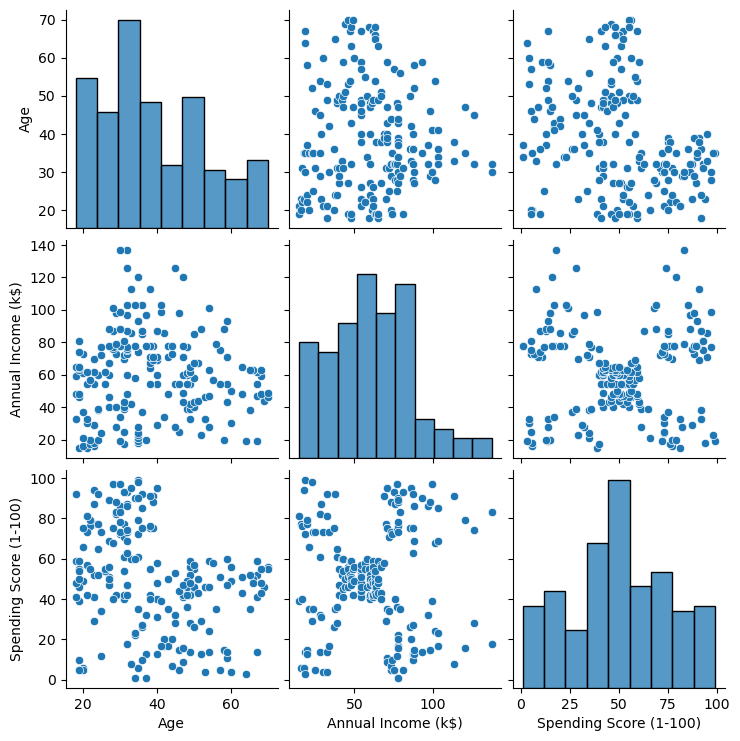

In [8]:
# Visualize pair-wise relationships between numerical columns

sns.pairplot(data=df.drop('CustomerID', axis=1));

Obs : `Annual Income (k$)` x `Spending Score (1-100)` appears to be good pair to cluster customers

## Preprocessing 
### dropping 'columns' that we don't need for now

In [9]:
# Create a copy of the DataFrame
df_copy = df.copy()

# Drop unnecessary columns ('CustomerID', 'Gender', 'Age')
df_copy = df_copy.drop(['CustomerID', 'Gender', 'Age'], axis=1)

# Display the first 3 rows of the preprocessed DataFrame
df_copy.head(3)

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6


### Feature Scaling with StandardScaler

In [10]:
# instantiate StandardScaler
scaler = StandardScaler()

# Select the columns to scale
columns_to_scale = ['Annual Income (k$)', 'Spending Score (1-100)']

# Fit the scaler to the selected columns and transform them
df_copy[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

## K-Means Clustering: Determining the Optimal Number of Clusters

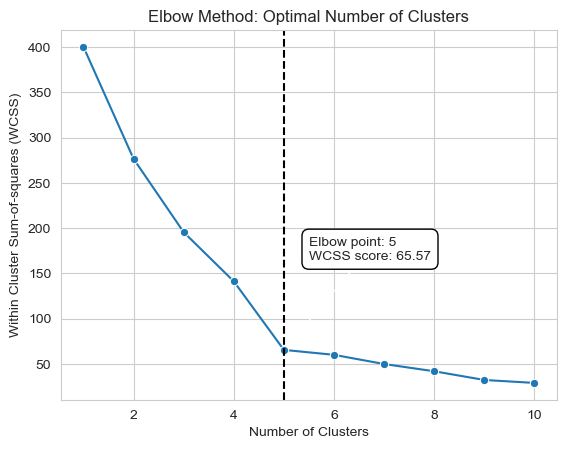

In [11]:
# Initialize an empty list to store the Within Cluster Sum-of-squares (WCSS) values
wcss = []

# Iterate over a range of potential cluster numbers
for i in range(1, 11):
    # Initialize KMeans with the current number of clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init='auto', random_state=42)
    
    # Fit KMeans to the data and compute WCSS
    kmeans.fit(df_copy)
    wcss.append(kmeans.inertia_)

# Locate the elbow point using the KneeLocator algorithm
kneedle = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')
elbow_point = kneedle.elbow    

# Visualize the WCSS values
sns.set_style("whitegrid")
plt.figure()
sns.lineplot(x=range(1, 11), y=wcss, marker='o')
plt.axvline(x=elbow_point, color='black', linestyle='--', label='Elbow point')

plt.title('Elbow Method: Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum-of-squares (WCSS)')

# Annotate the elbow point with its coordinates and WCSS score
plt.annotate(f'Elbow point: {elbow_point}\nWCSS score: {wcss[elbow_point-1]:.2f}',
             xy=(elbow_point, wcss[elbow_point-1]),
             xytext=(elbow_point + 0.5, wcss[elbow_point-1] + 100),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='black', lw=1))
plt.show()

### Training the actual algo with 5 cluster

In [12]:
# Initialize KMeans with 5 clusters and fit to the data
kmeans = KMeans(n_clusters=5, init='k-means++', n_init='auto', random_state=42)
kmeans_pred = kmeans.fit_predict(df_copy)

# Assign cluster labels to the DataFrame
df_copy['cluster'] = kmeans_pred

# Display the first few rows of the DataFrame with cluster assignments
df_copy.head()

,Annual Income (k$),Spending Score (1-100),cluster
0,-1.738999,-0.434801,2
1,-1.738999,1.195704,3
2,-1.700830,-1.715913,2
3,-1.700830,1.040418,3
4,-1.662660,-0.395980,2


### Visualizing Clusters in Annual Income vs. Spending Score

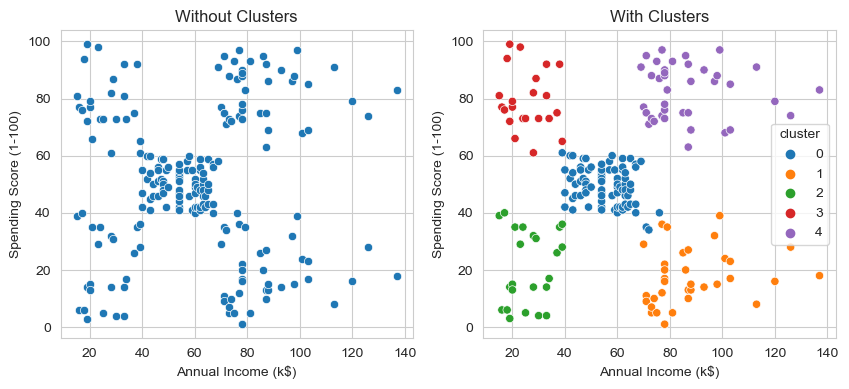

In [13]:
df['cluster'] = kmeans_pred

# Create subplots for side-by-side comparison
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot without clusters
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', ax=ax[0])
ax[0].set_title('Without Clusters')

# Plot with clusters
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='cluster', palette='tab10', ax=ax[1])
ax[1].set_title('With Clusters')

# Show the plot
plt.show()

### Validating Clustering Results with Silhouette Score

In [14]:
# Display the computed silhouette score
silhouette_avg = silhouette_score(df_copy, df_copy['cluster'])

# The silhouette score measures the quality of clustering results, ranging from -1 to 1.
# A general rule of thumb is that a silhouette score above 0.5 indicates a good clustering, 
# a silhouette score below 0.25 indicates a bad clustering, 
# and a silhouette score between 0.25 and 0.5 indicates a fair clustering.

print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.6915071284226041


## Additional Insights for Marketing Team on Targeting the Premium Group

In [15]:
# Filter customers in the premium cluster (cluster 4) from the original DataFrame
premium_cluster = df[df['cluster']==4].copy()

# Define age bins to categorize customers
bins = [0, 25, 30, 35, 40, float('inf')]
labels = ['<25', '25-30', '30-35', '35-40', '>=40']

# Categorize customers in the premium cluster based on age
premium_cluster['age_bin'] = pd.cut(premium_cluster['Age'], bins=bins, labels=labels, right=False)

# Generate a pivot table to show the distribution of customers in the premium cluster by age and gender
# This table provides insights into the demographics of the premium segment, allowing for targeted marketing strategies
premium_cluster[['Gender', 'age_bin']].pivot_table(index='age_bin', columns='Gender', aggfunc='size')

Gender,Female,Male
age_bin,,
<25,0,0
25-30,4,4
30-35,11,7
35-40,6,6
>=40,0,1


Obs : 
- More than 90% of premium segment are between **25 to 40yo**, making this our primary target range. 
- 53% of premium segment are females

### How do we entice these customers?

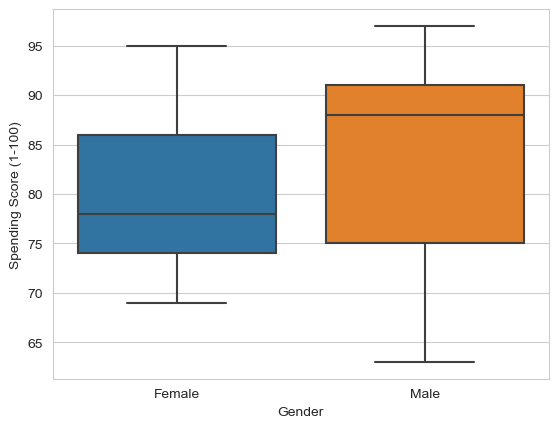

In [16]:
# Filter premium customers aged 25 to 39, as they represent a significant portion of the target demographic
premium_cluster_25_to_39 = premium_cluster[(premium_cluster['age_bin'] > '25-30') & (premium_cluster['age_bin'] < '>=40')].copy()

# Visualize the spending score distribution among premium customers aged 25 and above, segmented by gender
# This box plot helps identify differences in spending behavior between male and female customers
sns.boxplot(data=premium_cluster_25_to_39, x='Gender', y='Spending Score (1-100)');

Obs : box plot implies that 'Male' customer typically have higher `Spending Score`. On assumption that `Spending Score` measures customers' spending power, suggest to include higher priced items in our marketing mechanic for male customer.

## Conclusion

### Target Audience
- We can divide customers into 5 segments based on `Spending Score` and `Annual Income (k$)`
- Recommend to focus on cluster 4 : high `Spending Score` and high `Annual Income (k$)`

### Marketing Mechanic
- Focus on items popular amongst 25-39 years old
- Include higher priced items popular amongst male customers
- Include Lower - medium price item or stronger discounted items to entice the female customers